In [1]:
import numpy as np
from env import TransitNetworkEnv

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
from agent import GNNPolicy, FeatureExtractor
from stable_baselines3.common.callbacks import BaseCallback

from matplotlib import pyplot as plt
from stable_baselines3.common.utils import obs_as_tensor
from tqdm import tqdm

In [ ]:
def get_model(env):
    model = PPO(
        tensorboard_log="./logs/",
        policy=GNNPolicy,
        env=env,
        verbose=0,
        policy_kwargs=dict(
            features_extractor_class=FeatureExtractor,
            features_extractor_kwargs=dict(gnn_hidden_dim=64, 
                                           gnn_num_heads=4, 
                                           embed_size=128, 
                                           transformer_num_heads=4, 
                                           num_encoder_layers=6, 
                                           num_decoder_layers=6, 
                                           dropout_rate=0.1)),
        batch_size=36,
        n_steps=1080,
        learning_rate=lambda f: 5e-4 * f,
        gamma=0.999,
        n_epochs=10,
        device="cpu",
        ent_coef=0.02,
    )
    return model

In [ ]:
class InfoTensorboardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])

        for i, info in enumerate(infos):
            for key in info:
                self.logger.record(f"env/{key}", info[key], self.num_timesteps)
            
        return True
    
env = TransitNetworkEnv(seed = 0)
def make_env(seed):
    def _init():
        env = TransitNetworkEnv(seed=seed)
        return env
    return _init

n_envs = 6
env = SubprocVecEnv([make_env(seed=i*1000) for i in range(n_envs)])

callback = InfoTensorboardCallback()
model = get_model(env)
model.learn(total_timesteps=1080*10_000, log_interval=1, callback=callback, tb_log_name="first_run", reset_num_timesteps=False, progress_bar=False)
model.save("model")

100%|██████████| 1070/1070 [01:39<00:00, 10.70it/s]


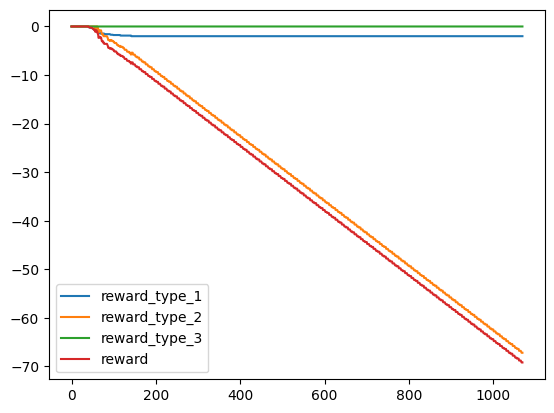

100%|██████████| 1070/1070 [01:13<00:00, 14.50it/s]


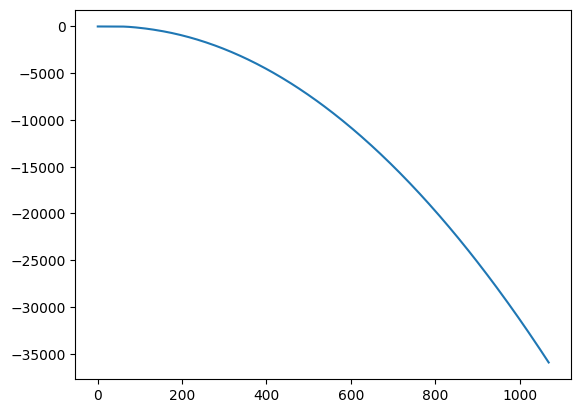

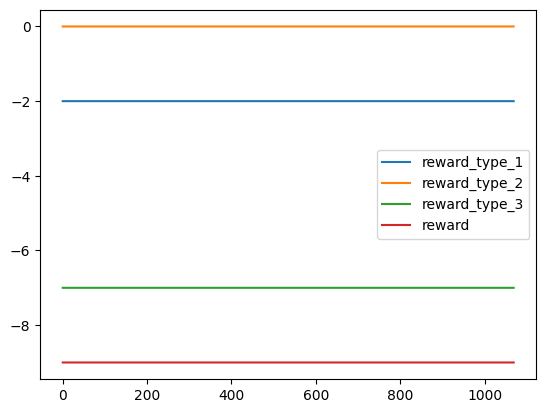

100%|██████████| 1070/1070 [01:04<00:00, 16.71it/s]


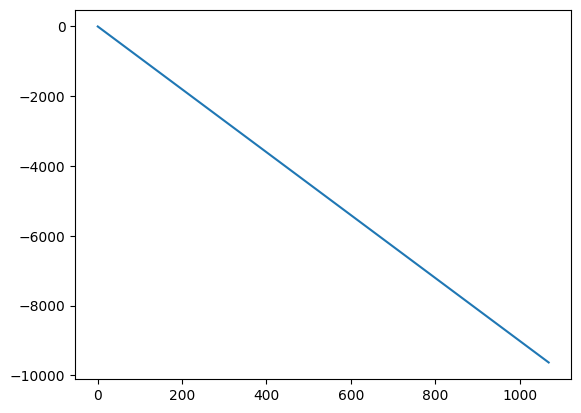

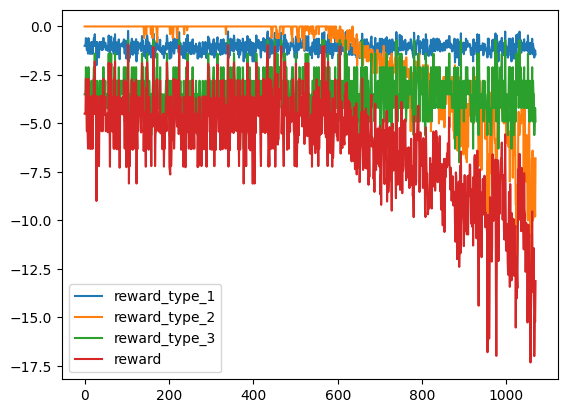

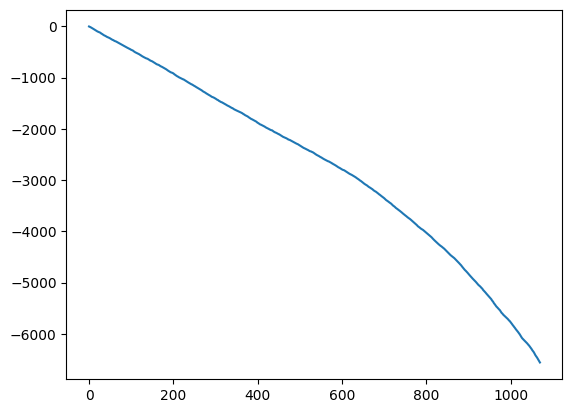

In [2]:
env = TransitNetworkEnv(seed = 0)
obs, _ = env.reset()
agnostic_rewards = []
infos = []
for i in tqdm(range(1070)):
    action = env.action_space.sample() * 0.0
    obs, reward, terminated, truncated, info = env.step(action.squeeze())
    agnostic_rewards.append(reward)
    infos.append(info)
    if terminated or truncated:
        break

import pandas as pd
df = pd.DataFrame(infos)
df.plot()
plt.show()
plt.plot(np.cumsum(agnostic_rewards))


env = TransitNetworkEnv(seed = 0)
obs, _ = env.reset()
agnostic_rewards = []
infos = []
for i in tqdm(range(1070)):
    action = env.action_space.sample() * 0.0 + 1
    obs, reward, terminated, truncated, info = env.step(action.squeeze())
    agnostic_rewards.append(reward)
    infos.append(info)
    if terminated or truncated:
        break

import pandas as pd
df = pd.DataFrame(infos)
df.plot()
plt.show()
plt.plot(np.cumsum(agnostic_rewards))

env = TransitNetworkEnv(seed = 0)
obs, _ = env.reset()
agnostic_rewards = []
infos = []
for i in tqdm(range(1070)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action.squeeze())
    agnostic_rewards.append(reward)
    infos.append(info)
    if terminated or truncated:
        break

import pandas as pd
df = pd.DataFrame(infos)
df.plot()
plt.show()
plt.plot(np.cumsum(agnostic_rewards))

In [ ]:
seed = 0
env = TransitNetworkEnv(seed = seed)
model = get_model(env)
model = model.load("model")
obs, _ = env.reset()
policy_rewards = []
for i in tqdm(range(1080)):
    action = model.policy.predict(obs_as_tensor(obs, device="cpu"))
    obs, reward, terminated, truncated, info = env.step(action.squeeze())
    policy_rewards.append(reward)
    if terminated or truncated:
        break

env = TransitNetworkEnv(seed = seed)
model = get_model(env)
obs, _ = env.reset()
random_policy_rewards = []
for i in tqdm(range(1080)):
    action = model.policy.predict(obs_as_tensor(obs, device="cpu"))
    obs, reward, terminated, truncated, info = env.step(action.squeeze())
    random_policy_rewards.append(reward)
    if terminated or truncated:
        break

env = TransitNetworkEnv(seed = seed)
obs, _ = env.reset()
agnostic_rewards = []
for i in tqdm(range(1080)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action.squeeze())
    agnostic_rewards.append(reward)
    if terminated or truncated:
        break

In [ ]:
plt.plot(policy_rewards, label="GNN")
plt.plot(random_policy_rewards, label="Random GNN")
plt.plot(agnostic_rewards, label="Data agnostic (Random)")
plt.legend()
print(f"GNN: {np.mean(policy_rewards):.3f}, Random: {np.mean(random_policy_rewards):.3f}, Agnostic: {np.mean(agnostic_rewards):.3f}")